In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode

In [2]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [3]:
def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains cosine distances, calculated metrics, and accuracy.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Task 1: Calculate and print mean distances for each group
    mean_control = np.mean(control_cosine_distances)
    mean_exp = np.mean(exp_cosine_distances)
    mean_sd = np.mean(sd_cosine_distances)

    print("Mean Cosine Distances:")
    print(f"Control Group: {mean_control:.4f}")
    print(f"Exploded Group: {mean_exp:.4f}")
    print(f"Single Dose Group: {mean_sd:.4f}")

    # Task 2: Find the group with the middle mean
    means = [mean_control, mean_exp, mean_sd]
    groups = ["Control", "Exploded", "Single Dose"]
    middle_index = np.argsort(means)[1]
    middle_group = groups[middle_index]
    print(f"Group with middle mean: {middle_group}")

    # Task 3: Determine middle cluster bounds
    middle_distances = [control_cosine_distances, exp_cosine_distances, sd_cosine_distances][middle_index]
    middle_cluster_min = np.min(middle_distances)
    middle_cluster_max = np.max(middle_distances)
    print(f"Middle cluster min: {middle_cluster_min:.4f}")
    print(f"Middle cluster max: {middle_cluster_max:.4f}")

    # Task 4: Error calculation
    first_cluster = [control_cosine_distances, exp_cosine_distances, sd_cosine_distances][np.argsort(means)[0]]
    third_cluster = [control_cosine_distances, exp_cosine_distances, sd_cosine_distances][np.argsort(means)[2]]

    errors_in_first_cluster = np.sum(first_cluster > middle_cluster_min)
    errors_in_third_cluster = np.sum(third_cluster < middle_cluster_max)
    total_errors = errors_in_first_cluster + errors_in_third_cluster

    total_points = len(control_cosine_distances) + len(exp_cosine_distances) + len(sd_cosine_distances)
    non_error_points = total_points - total_errors
    accuracy = non_error_points / total_points

    print(f"Total errors: {total_errors}")
    print(f"Accuracy: {accuracy:.4f}")

    # Plot histograms
    plt.hist(control_cosine_distances, bins=bins, alpha=0.5, label="Control Group")
    plt.hist(exp_cosine_distances, bins=bins, alpha=0.5, label="Exploded Group")
    plt.hist(sd_cosine_distances, bins=bins, alpha=0.5, label="Single Dose Group")
    plt.legend(loc="upper right")
    plt.title("Cosine Distance Histograms")
    plt.xlabel("Cosine Distance")
    plt.ylabel("Frequency")
    plt.show()

    # Return results
    return {
        "cosine_distances": {
            "control": control_cosine_distances,
            "exploded": exp_cosine_distances,
            "single_dose": sd_cosine_distances,
        },
        "group_means": {
            "control": mean_control,
            "exploded": mean_exp,
            "single_dose": mean_sd,
        },
        "middle_cluster": {
            "group": middle_group,
            "min": middle_cluster_min,
            "max": middle_cluster_max,
        },
        "total_errors": total_errors,
        "accuracy": accuracy,
    }


Mean Cosine Distances:
Control Group: 0.6163
Exploded Group: 0.2212
Single Dose Group: 0.5862
Group with middle mean: Single Dose
Middle cluster min: 0.4353
Middle cluster max: 0.7015
Total errors: 434
Accuracy: 0.2943


C:\Users\k54739\AppData\Local\Temp\ipykernel_201380\367429956.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

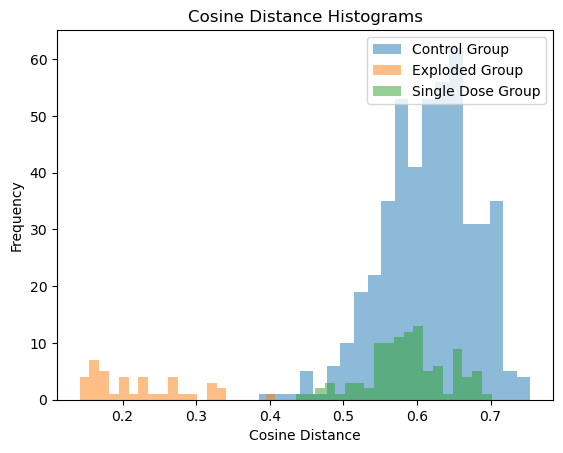

In [7]:
# File paths
exp_save_path_torch = r"ex.pt"
control_save_path_torch = r"condall.pt"
sd_save_path_torch = r"sd.pt"
centroid = r"ex.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    centroid,
    bins=20
)

Mean Cosine Distance Scores:
Control Group: 0.5536
Exploded Group: 0.5753
Single Dose Group: 0.2413

Dynamic Group Order and Mean Cosine Distances:
Single Dose Group Mean Cosine Distance: 0.2413
Control Group Mean Cosine Distance: 0.5536
Exploded Group Mean Cosine Distance: 0.5753


C:\Users\k54739\AppData\Local\Temp\ipykernel_11140\722150964.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\Te

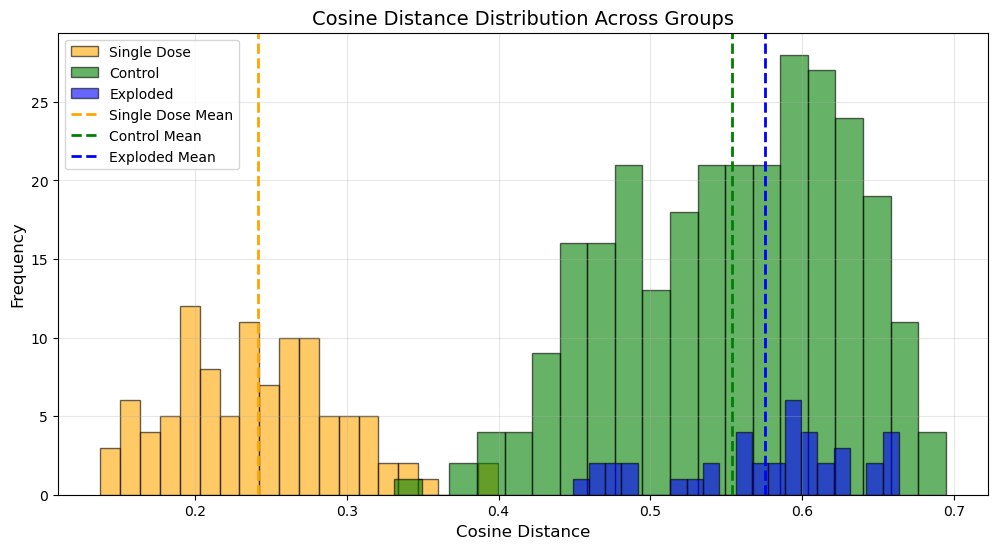


Metrics:
Group-Wise Ranking Accuracy: 0.9147

Dynamic Group Order: ['Single Dose', 'Control', 'Exploded']


In [2]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains cosine distances and calculated metrics.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Calculate mean distances for each group
    mean_control = np.mean(control_cosine_distances)
    mean_exp = np.mean(exp_cosine_distances)
    mean_sd = np.mean(sd_cosine_distances)

    # Print mean scores
    print("Mean Cosine Distance Scores:")
    print(f"Control Group: {mean_control:.4f}")
    print(f"Exploded Group: {mean_exp:.4f}")
    print(f"Single Dose Group: {mean_sd:.4f}")

    # Sort groups dynamically based on mean distances
    group_order = sorted(
        [(mean_control, control_cosine_distances, "Control", "green"),
         (mean_exp, exp_cosine_distances, "Exploded", "blue"),
         (mean_sd, sd_cosine_distances, "Single Dose", "orange")],
        key=lambda x: x[0]  # Sort by mean distance
    )

    # Map labels to the corresponding mean distance
    mean_map = {
        "Control": mean_control,
        "Exploded": mean_exp,
        "Single Dose": mean_sd
    }

    # Print the group order along with the corresponding mean distances
    print("\nDynamic Group Order and Mean Cosine Distances:")
    for _, _, label, _ in group_order:
        mean_distance = mean_map.get(label, None)
        if mean_distance is not None:
            print(f"{label} Group Mean Cosine Distance: {mean_distance:.4f}")
        else:
            print(f"Mean distance not found for {label}")

    # Plot histograms dynamically in sorted order
    plt.figure(figsize=(12, 6))
    for _, distances, label, color in group_order:
        plt.hist(distances, bins=bins, alpha=0.6, label=label, color=color, edgecolor="black")

    # Add vertical lines for mean distances
    for _, _, label, color in group_order:
        mean_distance = mean_map.get(label, None)
        if mean_distance is not None:
            plt.axvline(mean_distance, color=color, linestyle="dashed", linewidth=2, label=f"{label} Mean")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Compute Group-Wise Ranking Accuracy dynamically
    all_distances, all_labels = [], []
    for i, (_, distances, label, _) in enumerate(group_order):
        all_distances.append(distances)
        all_labels.append(np.full_like(distances, i))  # Assign dynamic labels based on sorted order

    all_distances = np.concatenate(all_distances)
    all_labels = np.concatenate(all_labels)
    
    group_wise_accuracy = compute_group_wise_ranking_accuracy(all_distances, all_labels)

    # Print metrics
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")

    # Return calculated distances and metrics for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances,
        "group_wise_accuracy": group_wise_accuracy,
        "mean_scores": {
            "Control": mean_control,
            "Exploded": mean_exp,
            "Single Dose": mean_sd
        },
        "group_order": [group[2] for group in group_order]  # Return the sorted group labels
    }

def compute_group_wise_ranking_accuracy(all_distances, all_labels):
    """
    Compute the Group-Wise Ranking Accuracy metric.

    Parameters:
        all_distances (np.ndarray): Combined cosine distances from all groups.
        all_labels (np.ndarray): Corresponding group labels for the distances.

    Returns:
        float: Group-wise ranking accuracy.
    """
    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]

    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1

    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy

# File paths
exp_save_path_torch = r"ex.pt"
control_save_path_torch = r"cond7.pt"
sd_save_path_torch = r"sd.pt"
sd_centroid = r"sd.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    sd_centroid,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]
group_order = distances["group_order"]
print("\nDynamic Group Order:", group_order)


Mean Cosine Distance Scores:
Control Group: 0.3065
Exploded Group: 0.5762
Single Dose Group: 0.5116

Dynamic Group Order and Mean Cosine Distances:
Control Group Mean Cosine Distance: 0.3065
Single Dose Group Mean Cosine Distance: 0.5116
Exploded Group Mean Cosine Distance: 0.5762


C:\Users\k54739\AppData\Local\Temp\ipykernel_11140\722150964.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\Te

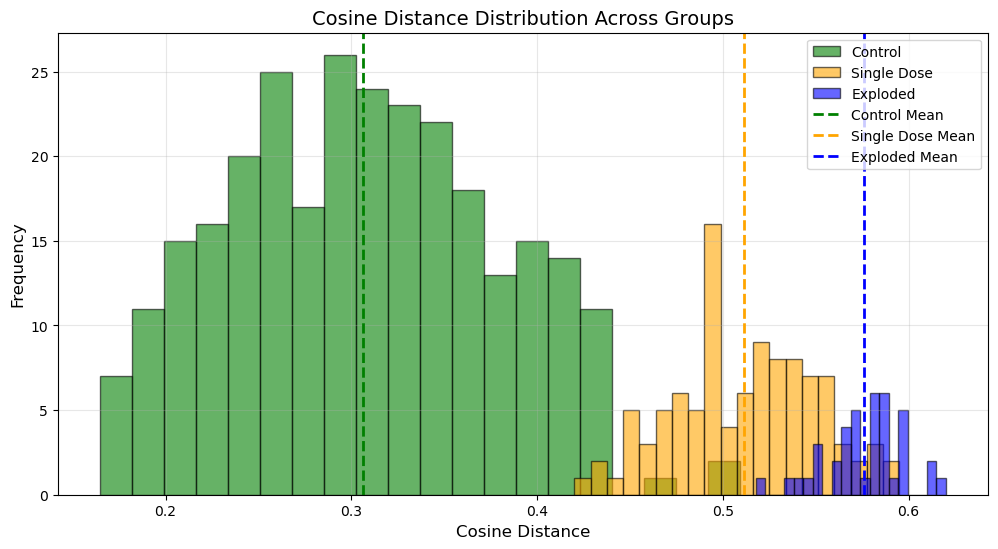


Metrics:
Group-Wise Ranking Accuracy: 0.9573


In [3]:
control_centroid = r"cond7.npy"
# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    control_centroid,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]

Mean Cosine Distance Scores:
Control Group: 0.6226
Exploded Group: 0.2212
Single Dose Group: 0.5862

Dynamic Group Order and Mean Cosine Distances:
Exploded Group Mean Cosine Distance: 0.2212
Single Dose Group Mean Cosine Distance: 0.5862
Control Group Mean Cosine Distance: 0.6226


C:\Users\k54739\AppData\Local\Temp\ipykernel_11140\722150964.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\Te

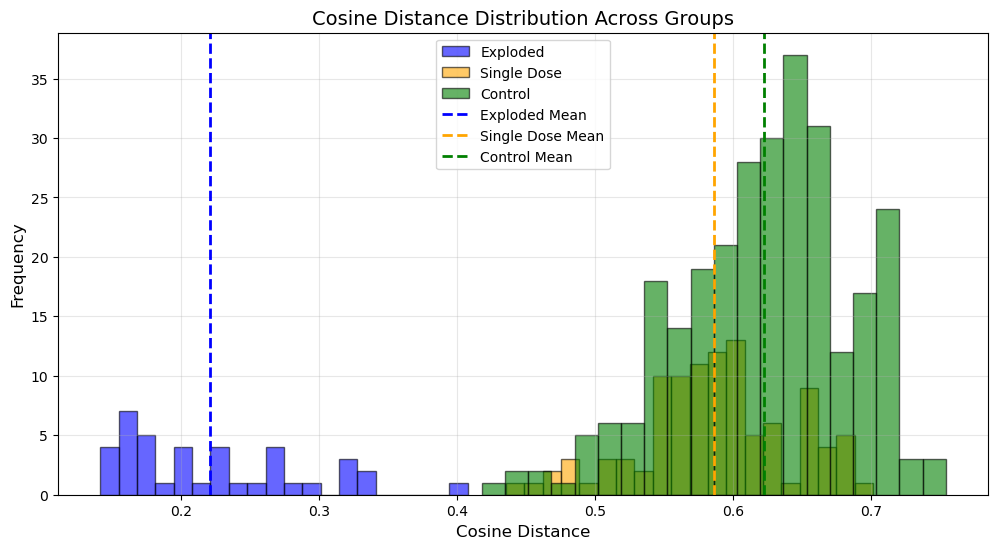


Metrics:
Group-Wise Ranking Accuracy: 0.8365


In [4]:
ex_centroid = r"ex.npy"
# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    ex_centroid,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]